# Capstone Project : Part.3

In [1]:
from sklearn.ensemble import GradientBoostingClassifier   # GBM
import xgboost as xgb         # XGBoost
import lightgbm as lgb        # LightGBM

from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import warnings

warnings.filterwarnings('ignore')

## 1. Load training & test data

In [2]:
X_train = pd.read_csv('data_set/merge/train_data.csv').drop('Unnamed: 0', axis = 1)
X_test = pd.read_csv('data_set/merge/test_data.csv').drop('Unnamed: 0', axis = 1)

## 2. Preprocessing  for modeling

In [3]:
# Split dataset to train and labels
y_train = X_train['TARGET']
X_train = X_train.drop(columns= ['TARGET'])

# Extract the id
test_ids = X_test['SK_ID_CURR']

# Align the training and testing data, keep only columns present in both dataframes
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Median imputation of missing values
imputer = Imputer(strategy='median')

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Converting y_train to a numpy array
y_train = y_train.as_matrix()

# Scoring Traing set's ROC_auc accuracy
def ROC_auc(model, train_data): 
    return (metrics.roc_auc_score(y_train, model.predict_proba(train_data)[:,1]))

print('Training Features shape: ', X_train.shape, type(X_train))
print('Testing Features shape: ', X_test.shape, type(X_test))
print('Target shape: ', y_train.shape, type(y_train))

('Training Features shape: ', (307511, 1912), <type 'numpy.ndarray'>)
('Testing Features shape: ', (48744, 1912), <type 'numpy.ndarray'>)
('Target shape: ', (307511,), <type 'numpy.ndarray'>)


## 3. Modeling

### 1) GBM

In [4]:
# Initialize GBM algorithm for binary classification 
gbm_model = GradientBoostingClassifier()

# Check train time
start_time = time.time()
gbm_model.fit(X_train, y_train)
end_time = time.time()

print("--- training time : %s seconds ---" % (end_time - start_time))
del start_time, end_time

# Training data's ROC score
gbm_train_score =  ROC_auc(gbm_model, X_train)

# Check predict time
start_time = time.time()
gbm_pred = gbm_model.predict_proba(X_test)[: , 1]
end_time = time.time()

# Submission dataframe
submission = pd.DataFrame({'SK_ID_CURR' : test_ids  , 'TARGET' : gbm_pred })
submission.to_csv('gbm_model.csv', index = False)

print("--- Excution time : %s seconds ---" % (end_time - start_time))
print("Training data AUC Score : ", gbm_train_score)
del start_time, end_time

--- training time : 3425.66608381 seconds ---
--- Excution time : 1.52076196671 seconds ---
('Training data AUC Score : ', 0.7827190533247388)


* Training data AUC Score :  0.783
* Submission's AUC Scored :  0.771


* Training Time : 3425.67 sec
* Excution Time : 1.5 sec

### 2) XGBoost

In [26]:
# Initialize and fit the model
xgb_model = xgb.XGBClassifier()

# Check time
start_time = time.time()
xgb_model.fit(X_train, y_train)
end_time = time.time()

print("--- training time : %s seconds ---" % (end_time - start_time))
del start_time, end_time

# Training data's ROC score
xgb_train_score =  ROC_auc(xgb_model, X_train)

# Chcek predict time
start_time = time.time()
xgb_pred = xgb_model.predict_proba(X_test)[: , 1]
end_time = time.time()

# Submission dataframe
submission = pd.DataFrame({'SK_ID_CURR' : test_ids  , 'TARGET' : xgb_pred })
submission.to_csv('xgb_model.csv', index = False)

print("--- Excution time : %s seconds ---" % (end_time - start_time))
print("Training data AUC Score : ", xgb_train_score)
del start_time, end_time

--- training time : 2195.4601419 seconds ---
--- Excution time : 4.2665040493 seconds ---
('Training data AUC Score : ', 0.7812002852167689)


* Training data AUC Score :  0.781
* Submission's AUC Scored : 0.769


* Training time : 2195.5 sec
* Excution time :     4.3 sec

### 3) LightGBM

In [5]:
# Initialize LightGBM algorithm for binary classification 
lgb_model = lgb.LGBMClassifier()

# Check train time
start_time = time.time()
lgb_model.fit(X_train, y_train)
end_time = time.time()

# Training data's ROC score
lgb_train_score =  ROC_auc(lgb_model, X_train)

print("--- Training time : %s seconds ---" % (end_time - start_time))
del start_time, end_time

# Chcek predict time
start_time = time.time()
lgb_pred = lgb_model.predict_proba(X_test)[: , 1]
end_time = time.time()

print("--- Excution time : %s seconds ---" % (end_time - start_time))
print("Training data AUC Score : ", lgb_train_score)

# Submission dataframe
submission = pd.DataFrame({'SK_ID_CURR' : test_ids  , 'TARGET' : lgb_pred })
submission.to_csv('lgb_model.csv', index = False)

#del lgb_model, lgb_pred,  lgb_param, start_time, end_time

--- Training time : 106.477459908 seconds ---
--- Excution time : 1.68322992325 seconds ---
('Training data AUC Score : ', 0.8249325747606943)


* Training data AUC Score :  0.825
* Submission's AUC Scored : 0.781


* Training time :  106.5 sec
* Excution time :     1.7 sec

### Scoring Classifier Models using scikit-learn

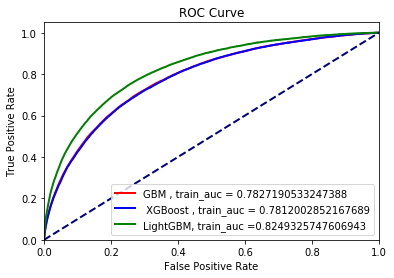

In [32]:
# Assign predict probability for metrics ROC auc 
gbm_pred_proba = gbm_model.predict_proba(X_train)[: , 1]
xgb_pred_proba = xgb_model.predict_proba(X_train)[: , 1]
light_pred_proba = lgb_model.predict_proba(X_train)[: , 1]

# Roc_curve metric for GBM with training set
gbm_fpr, gbm_tpr, _ = metrics.roc_curve(y_train,  gbm_pred_proba)
gbm_roc_auc = metrics.auc(gbm_fpr, gbm_tpr) 

# Roc_curve metric for XGBoost with training set
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_train, xgb_pred_proba)
xgb_roc_auc = metrics.auc(xgb_fpr, xgb_tpr)

# Roc_curve metric for LightGBM with training set
light_fpr, light_tpr, _ = metrics.roc_curve(y_train,  light_pred_proba)
light_roc_auc = metrics.auc(light_fpr, light_tpr)


plt.figure()

plt.plot(gbm_fpr, gbm_tpr, color='red', lw=2, label = 'GBM , train_auc = ' +str(gbm_roc_auc))
plt.plot(xgb_fpr, xgb_tpr, color='blue',  lw=2, label = ' XGBoost , train_auc = ' +str(xgb_roc_auc))
plt.plot(light_fpr, light_tpr, color='green', lw=2, label = 'LightGBM, train_auc =' +str(light_roc_auc))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
                                                
del gbm_pred_proba, light_pred_proba, gbm_fpr, gbm_tpr, _

## 4. Improve Result

### Parameter Tuning

 Implementation of LightGBM is easy but parameter tuning is difficult. In order to decide on boosting parameters, we need to set some initial values of other parameters. 
 
* max_depth: Specify the max depth to which tree will grow. This parameter is used to deal with overfitting.

* min_child_weight  : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.

* max_bin : max number of bins to bucket the feature values.

* subsample, colsample_bytree  : This is a commonly used used start value. Typical values range between 0.5-0.9.

##### Step 1 : max_depth & min_child_weight

In [236]:
# Set max_depth parameters for tuning
# It specifies the maximum depth or level up to which tree can grow.
param_test1 =  { 'max_depth':range(-1, 3, 5),
                'min_child_weight':range(2, 5, 7)}

grid_search1 = GridSearchCV(estimator = lgb.LGBMClassifier( boosting_type='gbdt',
                                                       learning_rate = 0.1, objective = 'binary', 
                                                       metric = 'binary_logloss', min_child_samples=20,
                                                       n_jobs=-1, num_leaves=129,
                                                       random_state=None), param_grid = param_test1, cv= 5 )
grid_search1.fit(X_train,y_train)

print('Grid score: ',grid_search1.grid_scores_,)

('Grid score: ', [mean: 0.91936, std: 0.00041, params: {'max_depth': -1, 'min_child_weight': 2}])


##### Step 2 : subsample & colsample_bytree

This step would be try different subsample and colsample_bytree values

In [16]:
# subsample : Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. (Typical values: 0.5-1)
# colsample_bytree : Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree. (Typical values: 0.5-1)

param_test2 = {'subsample':[0.5, 0.7, 0.9]}

grid_search2 = GridSearchCV(estimator = lgb.LGBMClassifier( boosting_type='gbdt',
                                                       learning_rate = 0.1, max_depth = -1,
                                                       objective = 'binary', metric = 'binary_logloss',
                                                       min_child_samples=2, n_jobs=-1,
                                                       num_leaves=129, random_state=None), param_grid = param_test2, cv= 5 )
grid_search2.fit(X_train,y_train)

print('Grid score: ',grid_search2.grid_scores_,)
print
print('Best parameters: ', grid_search2.best_params_,)

('Grid score: ', [mean: 0.91601, std: 0.00262, params: {'subsample': 0.5}, mean: 0.91601, std: 0.00262, params: {'subsample': 0.7}, mean: 0.91601, std: 0.00262, params: {'subsample': 0.9}])


In [18]:
param_test3 = { 'colsample_bytree':[0.5, 0.7, 0.9]}

grid_search3 = GridSearchCV(estimator = lgb.LGBMClassifier( boosting_type='gbdt',
                                                       learning_rate = 0.1, max_depth = -1,
                                                       objective = 'binary', metric = 'binary_logloss',
                                                       min_child_samples=2, n_jobs=-1,
                                                       sub_sample = 0.9, num_leaves=129,
                                                       random_state=None), param_grid = param_test3, cv= 5 )

grid_search3.fit(X_train,y_train)

print('Grid score: ',grid_search3.grid_scores_,)
print
print('Best parameters: ', grid_search3.best_params_,)

('Grid score: ', [mean: 0.91699, std: 0.00188, params: {'colsample_bytree': 0.5}, mean: 0.91681, std: 0.00211, params: {'colsample_bytree': 0.7}, mean: 0.91634, std: 0.00242, params: {'colsample_bytree': 0.9}])


##### Step 3 :  learning_rate

In [37]:
# Set num_leaves parameters
# This parameter is lower the learning rate
param_test4 = {'learning_rate' : [0.001, 0.003, 0.005, 0.1]}

grid_search4 = GridSearchCV(estimator = lgb.LGBMClassifier( boosting_type='gbdt', 
                                                           max_depth = -1, objective = 'binary', 
                                                           metric = 'binary_logloss', min_child_samples=2,
                                                           n_jobs=-1, subsample = 0.5,
                                                           colsample_bytree = 0.5, num_leaves=129,
                                                           random_state=None), param_grid = param_test4, cv= 5 )

grid_search4.fit(X_train,y_train)

print('Grid score: ',grid_search4.grid_scores_,)
print
print('Best parameters: ', grid_search4.best_params_,)

('Grid score: ', [mean: 0.91927, std: 0.00000, params: {'learning_rate': 0.001}, mean: 0.91927, std: 0.00000, params: {'learning_rate': 0.003}, mean: 0.91927, std: 0.00000, params: {'learning_rate': 0.005}])

('Best parameters: ', {'learning_rate': 0.001})


##### Step 4 : num_iteration

In [56]:
# This parameter is number of boosting iterations. Default is 100
# Use small learning_rate with large num_iterations for better accuracy
param_test6 = {'num_iteration' : [100, 200, 300]}

grid_search6 = GridSearchCV(estimator = lgb.LGBMClassifier( boosting_type='gbdt', 
                                                           learning_rate = 0.001, max_depth = -1,
                                                           objective = 'binary', metric = 'binary_logloss',
                                                           min_child_samples=2,n_jobs=-1,
                                                           subsample = 0.5,colsample_bytree = 0.5,
                                                           num_leaves=129, random_state=None), param_grid = param_test6, cv= 5)

grid_search6.fit(X_train,y_train)

print('Grid score: ',grid_search6.grid_scores_,)
print
print('Best parameters: ', grid_search6.best_params_,)

('Grid score: ', [mean: 0.91927, std: 0.00000, params: {'num_iteration': 100}, mean: 0.91927, std: 0.00000, params: {'num_iteration': 200}, mean: 0.91927, std: 0.00000, params: {'num_iteration': 300}])

('Best parameters: ', {'num_iteration': 100})


##### Step 5 : max_bin

In [54]:
# This parameter's default is 255.
# Small max_bin value may reduce training accuracy but may increase general power (deal with over-fit)
param_test5 = {'max_bin' : [255, 280]}

grid_search5 = GridSearchCV(estimator = lgb.LGBMClassifier( boosting_type='gbdt',
                                                           learning_rate = 0.001, max_depth = -1,
                                                           objective = 'binary', metric = 'binary_logloss',
                                                           min_child_samples=2, n_jobs=-1,
                                                           subsample = 0.5,
                                                           colsample_bytree = 0.5,
                                                           num_leaves=129,
                                                           random_state=None), param_grid = param_test5, cv= 5 )

grid_search5.fit(X_train,y_train)

print('Grid score: ',grid_search5.grid_scores_,)
print
print('Best parameters: ', grid_search5.best_params_,)

('Grid score: ', [mean: 0.91927, std: 0.00000, params: {'max_bin': 255}, mean: 0.91927, std: 0.00000, params: {'max_bin': 280}])

('Best parameters: ', {'max_bin': 255})


In [186]:
# Save optimized parameters
best_param = grid_search6.best_estimator_

### Final Model Evaluation

In [167]:
# Cloning the model
from sklearn.base import clone

# Initialize after tuning model
final_tune_model = clone(best_param)

# Check train time
start_time = time.time()
final_tune_model.fit(X_train, y_train)
end_time = time.time()

# Training data's ROC score
lgb_train_score =  ROC_auc(final_tune_model, X_train)

print("--- Training time : %s seconds ---" % (end_time - start_time))
del start_time, end_time

# Chcek predict time
start_time = time.time()
lgb_pred = final_tune_model.predict_proba(X_test)[: , 1]
end_time = time.time()

print("--- Excution time : %s seconds ---" % (end_time - start_time))
print("Training data AUC Score : ", lgb_train_score)

# Submission dataframe
submission = pd.DataFrame({'SK_ID_CURR' : test_ids  , 'TARGET' : lgb_pred })
submission.to_csv('initial_model.csv', index = False)

--- Training time : 120.401747227 seconds ---
--- Excution time : 3.24778103828 seconds ---
('Training data AUC Score : ', 0.8249325747606943)


##### Report the before & after optimize

It was improved a little. Parameter tuning process is very tedious and difficult. 

In [172]:
print('Unoptimized model \n --------------------------')
print("ROC auc score on training data: ", 0.825)
print("Submission score on testing data: ",0.781 )
print("\nOptimized Model\n---------------------------")
print("ROC auc score on the training data: ", 0.8249)
print("Submission score on the testing data: ", 0.783)

Unoptimized model 
 --------------------------
('ROC auc score on training data: ', 0.825)
('Submission score on testing data: ', 0.781)

Optimized Model
---------------------------
('ROC auc score on the training data: ', 0.8249)
('Submission score on the testing data: ', 0.783)


## 5. Feature Importance

For better result, I will remove zero importance features using FeatureSelector class. Below chart ranks the importance of each feature when making predictions.

In [68]:
from feature_selector import FeatureSelector

# Import train & test data to select most important features
feature_train = pd.read_csv('data_set/merge/train_data.csv').drop('Unnamed: 0', axis = 1)
feature_test =  pd.read_csv('data_set/merge/test_data.csv').drop('Unnamed: 0', axis = 1)
feature_label = feature_train['TARGET']

fs = FeatureSelector(data = feature_train.drop('TARGET', axis= 1) , labels= feature_label)

In [70]:
# Find features with 0.0 importance from a gradient boosting machine
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[516]	valid_0's auc: 0.787214
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[605]	valid_0's auc: 0.788916
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[740]	valid_0's auc: 0.787828
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[575]	valid_0's auc: 0.791376
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[438]	valid_0's auc: 0.791594
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[646]	valid_0's auc: 0.786788
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[415]	valid_0's auc: 0.786678
Training until validation scores don't improve for 100 rounds.
Early s

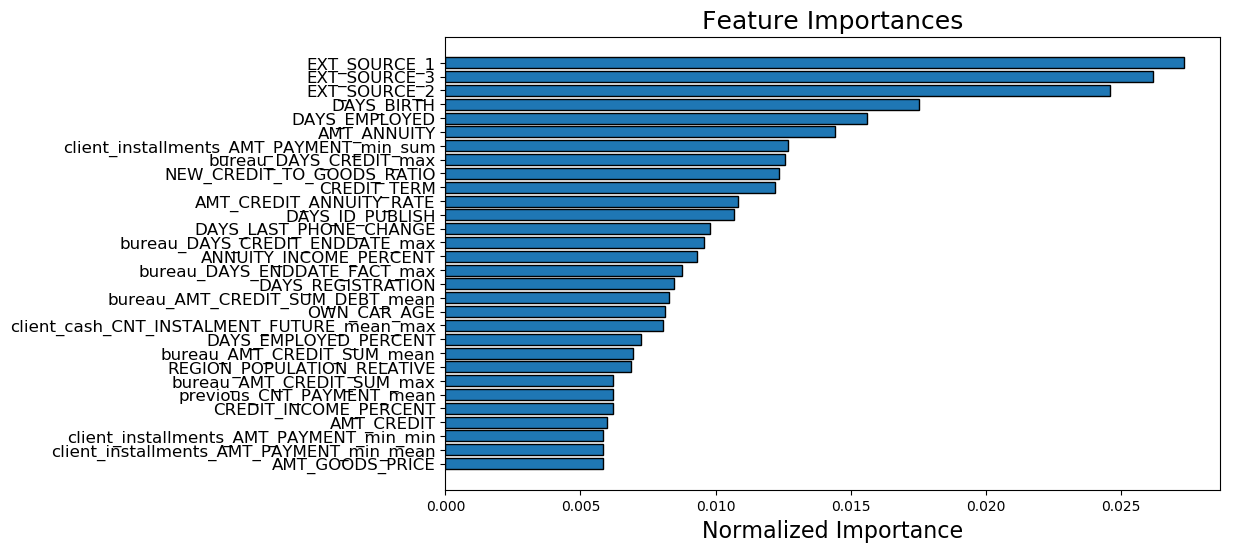

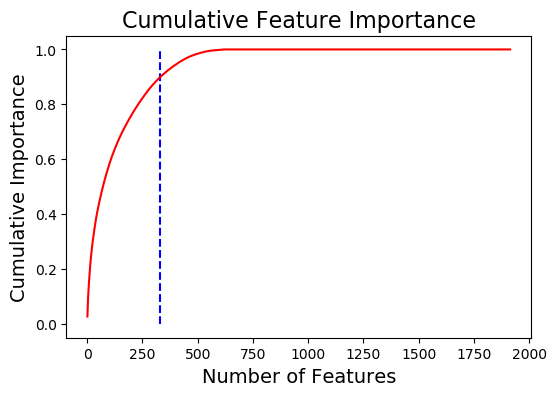

331 features required for 0.90 of cumulative importance


In [71]:
# Ranks most important features
fs.plot_feature_importances(threshold = 0.9, plot_n = 30)

In [153]:
# It will extract  zero importance features both train set and test set
zero_importance = fs.ops['zero_importance']
final_train = fs.remove(methods = ['zero_importance'])

for i in feature_test.columns:
    if i in zero_importance:
        feature_test.drop(columns= i)

#  Remove 1300 of zero importance features 
final_train = fs.remove(methods = ['zero_importance'])

In [161]:
# Extract the id
test_ids = feature_test['SK_ID_CURR']

# Median imputation of missing values
imputer = Imputer(strategy='median')

# Fit on the training data
imputer.fit(final_train)

# Transform both training and testing data
eva_train = imputer.transform(final_train)
eva_test = imputer.transform(feature_test)

# Converting y_train to a numpy array
feature_label = feature_label.as_matrix()

## 6. Feature Selection

Now, we will use the same optimized model you found earlier, and train it on the same training set without zero important features.

In [188]:
# Clone LightGBM algorithm with best_estimators 
select_feature_model =   clone(best_param)

# Check train time
start_time = time.time()
select_feature_model.fit(eva_train, feature_label)
end_time = time.time()

# Training data's ROC score
lgb_train_score =  ROC_auc(select_feature_model, eva_train)

print("--- Training time : %s seconds ---" % (end_time - start_time))
del start_time, end_time

# Chcek predict time
start_time = time.time()
reduced_pred = select_feature_model.predict_proba(eva_test)[: , 1]
end_time = time.time()

print("--- Excution time : %s seconds ---" % (end_time - start_time))
print("Training data AUC Score : ", lgb_train_score)

# Submission dataframe
submission = pd.DataFrame({'SK_ID_CURR' : test_ids  , 'TARGET' : reduced_pred })
submission.to_csv('select_feature_model.csv', index = False)

--- Training time : 50.5382070541 seconds ---
--- Excution time : 1.108273983 seconds ---
('Training data AUC Score : ', 0.7805091915740614)


* Training data AUC Score :  0.780
* Submission's AUC Scored : 0.747


* Training time :  50.5382070541 seconds
* Excution time : 1.108273983 seconds

Feature Selcetion process recorded lower ROC auc score both train and test set than earlier 